### Load Data Sets

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

fakenews_pd = pd.read_csv("./Fake.csv")
realnews_pd = pd.read_csv("./True.csv")

2022-12-12 17:40:16.730784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# preliminary cleanup for accurate EDA, get rid of articles in the fakenews df that has
# only empty spaces in the text column (like videos)

fakenews_pd = fakenews_pd[~fakenews_pd['text'].isin(['  ', ' '])]

### EDA

#### Fake news

In [3]:
# fake news - average words per article

fn_list = list(fakenews_pd['text'])
fn_len = [len(item.split()) for item in fn_list]
sum(fn_len)/len(fn_len)

434.8654325850072

In [4]:
# fake news - average sentences per article

fn_list_list = [[item] for item in fn_list]
fn_list_len = [[len(item.split(".")) for item in sublist] for sublist in fn_list_list]
fn_list_len = [item for sublist in fn_list_len for item in sublist]
sum(fn_list_len)/len(fn_list_len)

22.48181698831561

In [5]:
# fake news sentence stats

fake_sents = pd.Series(fn_list_len)
fake_sents.describe()

count    22851.000000
mean        22.481817
std         20.116143
min          1.000000
25%         12.000000
50%         19.000000
75%         27.000000
max        556.000000
dtype: float64

In [6]:
# count fake articles with fewer than 4 sentences in text

sum(i < 4 for i in fn_list_len)

1290

In [7]:
# count fake articles with fewer than 3 sentences in text

sum(i < 3 for i in fn_list_len)

877

#### Real news

In [8]:
# real news - average words per article

rn_list = list(realnews_pd['text'])
rn_len = [len(item.split()) for item in rn_list]
sum(rn_len)/len(rn_len)

385.6400989867862

In [9]:
# real news - average sentences per article

rn_list = list(realnews_pd['text'])
rn_list_list = [[item] for item in rn_list]
rn_list_len = [[len(item.split(".")) for item in sublist] for sublist in rn_list_list]
rn_list_len = [item for sublist in rn_list_len for item in sublist]
sum(rn_list_len)/len(rn_list_len)

21.982724004295655

In [10]:
# real news sentence stats

real_sents = pd.Series(rn_list_len)
real_sents.describe()

count    21417.000000
mean        21.982724
std         15.972420
min          1.000000
25%          9.000000
50%         19.000000
75%         30.000000
max        283.000000
dtype: float64

In [11]:
# count fake articles with fewer than 4 sentences in text

sum(i < 4 for i in fn_list_len)

1290

In [12]:
# count fake articles with fewer than 3 sentences in text

sum(i < 3 for i in rn_list_len)

95

### Cleanup

In [13]:
# convert the text and title columns to lists for each data article data frame

fn_list_text = fakenews_pd['text'].tolist()
fn_list_title = fakenews_pd['title'].tolist()
rn_list_text = realnews_pd['text'].tolist()
rn_list_title = realnews_pd['title'].tolist()

Fake News

In [14]:
# define fake news clean up function

def fn_cleanup(list):

    # remove periods from acronyms
    fn_list_acro_fix = [re.sub(r'(?<!\w)([A-Z])\.', r'\1', text) for text in list]

    # remove twitter pics and credits
    fn_list_no_twitpics = [re.sub(r'pic.twitter[\S ]+?[\d]{4}','', text) for text in fn_list_acro_fix]

    # remove twitter handles
    fn_list_no_twitter = [re.sub(r'\(@_[\w\d]+\)|\(@[\w\d]+\)|@[\w\d]+|@_[\w\d]+', ' ', text) for text in fn_list_no_twitpics]

    # remove url links
    fn_list_no_links = [re.sub(r'https\:[\S]+|pic.twitter[\S]+','', text) for text in fn_list_no_twitter]

    # remove photo credits
    fn_list_no_photo_creds = [re.sub(r'Photo by[\S ]+\Z|Featured image[\S ]+\Z', '', text) for text in fn_list_no_links]

    # remove hashtags
    fn_list_no_hashtags = [re.sub(r'\#[\S]+', '', text) for text in fn_list_no_photo_creds]

    # replace dashes with spaces
    fn_list_no_dashes = [text.replace("-", " ") for text in fn_list_no_hashtags]

    # separate sentences with space if no space after period
    fn_list_add_spaces = [re.sub(r'((?<=[\w\d][\.\?\!])[\w\d])', r' \1', text) for text in fn_list_no_dashes]

    # remove dates
    fn_list_no_dates = [re.sub(r'[\w]+ [\d]{1,2}\, [\d]{4}', '', text) for text in fn_list_add_spaces]

    # add space between dates and sentence beginnings
    fn_list_fix_spaces = [re.sub(r'((?<=[0-9]{4})\w)', r' \1', text) for text in fn_list_no_dates]

    # remove numbers if in the middle of words
    fn_list_fix_alnums = [re.sub(r'(?<=[a-zA-Z])[\d]+|(?<=[a-zA-Z])[\d]+(?=[a-zA-Z])|[\d]+(?=[a-zA-Z])', '', text) for text in fn_list_fix_spaces]

    # join contractions with apostrophe (currently the 't' is separated with a space) then separate them into verb_not
    fn_list_fix_conts1 = [re.sub(r'([a-zA-Z]+) (?=t )', r"\1'", text).rstrip() for text in fn_list_fix_alnums]
    fn_list_fix_conts2 = [re.sub(r'([a-zA-Z]+) (?=ll )', r"\1'", text).rstrip() for text in fn_list_fix_conts1]
    fn_list_fix_conts3 = [re.sub(r'([a-zA-Z]+) (?=s )', r"\1'", text).rstrip() for text in fn_list_fix_conts2]
    fn_list_fix_conts = [contractions.fix(text) for text in fn_list_fix_conts3]

    return fn_list_fix_conts

In [15]:
# clean up fake news whole text and title lists

fn_cleanup_text = fn_cleanup(fn_list_text)
fn_cleanup_title = fn_cleanup(fn_list_title)

In [16]:
# define fake news transform function that shapes data to fit LSTM input

def fn_consolidate(list):
    
    # sentence tokenize unless summary
    if list == fn_cleanup_title or list == fn_cleanup_text:

        fn_sent_toks = [sent_tokenize(item) for item in list]

        # word tokenize
        fn_word_tokens = [[word_tokenize(word) for word in sentence] for sentence in fn_sent_toks]

    else:

        # word tokenize
        fn_word_tokens = [[word_tokenize(word) for word in sentence] for sentence in list]


    # retain only words
    fn_word_alphas = [[[word for word in sentence if word.isalpha()] for sentence in text] for text in fn_word_tokens]

    # convert to lowercase
    fn_word_lower = [[[word.lower() for word in sentence] for sentence in text] for text in fn_word_alphas]

    # remove stop words
    fn_word_nostops = [[[word for word in sentence if word not in stopwords.words('english')] for sentence in text] for text in fn_word_lower]

    # lemmatize words
    lem = WordNetLemmatizer()
    # fn_words_lemma = [[[lem.lemmatize(word) for word in sentence] for sentence in text] for text in fn_word_lower]
    fn_words_lemma = [[[lem.lemmatize(word) for word in sentence] for sentence in text] for text in fn_word_nostops]

    # put words back into sentences (detokenize)
    fn_words_detokenized = [[[TreebankWordDetokenizer().detokenize(sentence)] for sentence in text] for text in fn_words_lemma]

    # group sentences in article back together
    fn_sentences = [[sentence for sub_list in text for sentence in sub_list] for text in fn_words_detokenized]

    # add periods back to ends of sentences so they can be identified by LSTM
    fn_clean_text = [[(sentence + ". ") for sentence in text] for text in fn_sentences]
    fn_clean_text_join = ["".join(text) for text in fn_clean_text]

    return fn_clean_text_join


In [17]:
# transform fake news whole text and title lists

fn_join_title = fn_consolidate(fn_cleanup_title)
fn_join_text = fn_consolidate(fn_cleanup_text)

In [18]:
# save transformed text as np arrays to be reloaded below

fn_join_title_array = np.array(fn_join_title, dtype=object)
fn_join_text_array = np.array(fn_join_text, dtype=object)
np.save("fn_join_title", fn_join_title_array)
np.save("fn_join_text", fn_join_text_array)


Real news

In [19]:
# define real news clean up function

def rn_cleanup(list):

    # remove periods from acronyms
    rn_list_acro_fix = [re.sub(r'(?<!\w)([A-Z])\.', r'\1', text) for text in list]

    # remove Reuters news desk locations
    rn_list_no_newsdesk = [re.sub(r'\A[\S\/. ]*\(Reuters\) - |NEW YORK/WASHINGTON (Reuters) - ','', text) for text in rn_list_acro_fix]

    # remove twitter handles
    rn_list_no_twitter = [re.sub(r'@[\w]+|@_[\w]+|\(@_[\w]+\)', '', text) for text in rn_list_no_newsdesk]

    # remove latin1 spaces ('xa0')
    rn_list_no_twitter = [text.replace(u'\xa0', u' ') for text in rn_list_no_twitter]

    # remove bitly urls
    rn_list_no_links = [re.sub(r' -- Source link: [\S ]*\Z|bit\.ly[\/\w]+','', text) for text in rn_list_no_twitter]

    # remove timestamps
    rn_list_no_timestamps = [re.sub(r'\[[\w\d:\ ]*\]','', text) for text in rn_list_no_links]

    # Reuters prints a disclaimer before every twitter statement that the views expressed are not their own
    rn_clean_list = [re.sub(r'The following [\S ]+ \: \- ', '', text) for text in rn_list_no_timestamps]

    # join contractions with apostrophe (currently the 't' is separated with a space) then separate them into verb_not
    rn_list_fix_conts1 = [re.sub(r'([a-zA-Z]+) (?=t )', r"\1'", text).rstrip() for text in rn_clean_list]
    rn_list_fix_conts2 = [re.sub(r'([a-zA-Z]+) (?=ll )', r"\1'", text).rstrip() for text in rn_list_fix_conts1]
    rn_list_fix_conts3 = [re.sub(r'([a-zA-Z]+) (?=s )', r"\1'", text).rstrip() for text in rn_list_fix_conts2]
    rn_list_fix_conts = [contractions.fix(text) for text in rn_list_fix_conts3]

    return rn_list_fix_conts

In [20]:
# clean up real news whole text and title lists

rn_cleanup_text = rn_cleanup(rn_list_text)
rn_cleanup_title = rn_cleanup(rn_list_title)

In [21]:
# define real news transform function that shapes data to fit LSTM input

def rn_consolidate(list):

    # sentence tokenize unless summary
    if list == rn_cleanup_title or list == rn_cleanup_text:

        rn_sent_toks = [sent_tokenize(item) for item in list]

        # word tokenize
        rn_word_tokens = [[word_tokenize(word) for word in sentence] for sentence in rn_sent_toks]

    else:

        # word tokenize
        rn_word_tokens = [[word_tokenize(word) for word in sentence] for sentence in list]

    # retain only words
    rn_word_alphas = [[[word for word in sentence if word.isalpha()] for sentence in text] for text in rn_word_tokens]

    # convert to lowercase
    rn_word_lower = [[[word.lower() for word in sentence] for sentence in text] for text in rn_word_alphas]

    # remove stop words
    rn_word_nostops = [[[word for word in sentence if word not in stopwords.words('english')] for sentence in text] for text in rn_word_lower]

    # lemmatize words
    lem = WordNetLemmatizer()
    # rn_words_lemma = [[[lem.lemmatize(word) for word in sentence] for sentence in text] for text in rn_word_lower]
    rn_words_lemma = [[[lem.lemmatize(word) for word in sentence] for sentence in text] for text in rn_word_nostops]

    # put words back into sentences (detokenize)
    rn_words_detokenized = [[[TreebankWordDetokenizer().detokenize(sentence)] for sentence in text] for text in rn_words_lemma]

    # group sentences in article back together
    rn_sentences = [[sentence for sub_list in text for sentence in sub_list] for text in rn_words_detokenized]

    # add periods back to ends of sentences so they can be identified by LSTM
    rn_clean_text = [[(sentence + ". ") for sentence in text] for text in rn_sentences]
    rn_clean_text_join = ["".join(text) for text in rn_clean_text]

    return rn_clean_text_join

In [22]:
# transform real news whole text and title lists

rn_join_title = rn_consolidate(rn_cleanup_title)
rn_join_text = rn_consolidate(rn_cleanup_text)

In [23]:
# save processed text as np arrays to be reloaded below

rn_join_title_array = np.array(rn_join_title, dtype=object)
rn_join_text_array = np.array(rn_join_text, dtype=object)
np.save("rn_join_title", rn_join_title_array)
np.save("rn_join_text", rn_join_text_array)


### TextRank

In [24]:
# define text rank function

def text_summarize(text_list, num_sents):

    from gensim.summarization.textcleaner import split_sentences
    from gensim.summarization.summarizer import summarize

    text_summaries = []
    for text in text_list:
        sentence_list = split_sentences(text)
        sent_len = len(sentence_list)
        if 0 < sent_len < num_sents:
            text_summaries.append(sentence_list[:sent_len])
        else:
            temp_summaries = []
            temp_summaries.append(summarize(text, word_count=200))
            text_summaries.append(temp_summaries[0].split("\n", num_sents)[:num_sents])
            
    return text_summaries

In [25]:
# create 3 and 4 sentence fake news summaries

fn_summ3 = text_summarize(fn_cleanup_text, 3)
fn_summ4 = text_summarize(fn_cleanup_text, 4)

# transform 3 and 4 sentence fake news summaries

fn_summ3_join = fn_consolidate(fn_summ3)
fn_summ4_join = fn_consolidate(fn_summ4)

In [26]:
# save fake news summaries as np arrays to be reloaded below

fn_join_summ3_array = np.array(fn_summ3_join, dtype=object)
fn_join_summ4_array = np.array(fn_summ4_join, dtype=object)
np.save("fn_join_summ3", fn_join_summ3_array)
np.save("fn_join_summ4", fn_join_summ4_array)


In [27]:
# create 3 and 4 sentence real news summaries

rn_summ3 = text_summarize(rn_cleanup_text, 3)
rn_summ4 = text_summarize(rn_cleanup_text, 4)

# transform 3 and 4 sentence real news summaries

rn_summ3_join = fn_consolidate(rn_summ3)
rn_summ4_join = fn_consolidate(rn_summ4)

In [28]:
# save real news summaries as np arrays to be reloaded below

rn_join_summ3_array = np.array(rn_summ3_join, dtype=object)
rn_join_summ4_array = np.array(rn_summ4_join, dtype=object)
np.save("rn_join_summ3", rn_join_summ3_array)
np.save("rn_join_summ4", rn_join_summ4_array)

In [29]:
# create new column in realnews_pd with and add cleaned text to each row

fn_clean_title_load = np.load("fn_join_title.npy", allow_pickle=True).tolist()
fn_clean_text_load = np.load("fn_join_text.npy", allow_pickle=True).tolist()
fn_clean_summ3_load = np.load("fn_join_summ3.npy", allow_pickle=True).tolist()
fn_clean_summ4_load = np.load("fn_join_summ4.npy", allow_pickle=True).tolist()

rn_clean_title_load = np.load("rn_join_title.npy", allow_pickle=True).tolist()
rn_clean_text_load = np.load("rn_join_text.npy", allow_pickle=True).tolist()
rn_clean_summ3_load = np.load("rn_join_summ3.npy", allow_pickle=True).tolist()
rn_clean_summ4_load = np.load("rn_join_summ4.npy", allow_pickle=True).tolist()

fakenews_pd['cleaned_title'] = fn_clean_title_load
fakenews_pd['cleaned_text'] = fn_clean_text_load
fakenews_pd['cleaned_summ3'] = fn_clean_summ3_load
fakenews_pd['cleaned_summ4'] = fn_clean_summ4_load

realnews_pd['cleaned_title'] = rn_clean_title_load
realnews_pd['cleaned_text'] = rn_clean_text_load
realnews_pd['cleaned_summ3'] = rn_clean_summ3_load
realnews_pd['cleaned_summ4'] = rn_clean_summ4_load

In [30]:
# add label column with 1 for fakenews and 0 for realnews
fakenews_pd['label'] = 1
realnews_pd['label'] = 0

# combine the dataframes, shuffle rows, and reset the index
news = [fakenews_pd, realnews_pd]
news_df = pd.concat(news).sample(frac = 1)
news_df.reset_index(inplace=True)
news_df.drop(columns = ['index'], inplace=True)
news_df.head()

,title,text,subject,date,cleaned_title,cleaned_text,cleaned_summ3,cleaned_summ4,label
0,Mistrial declared in corruption case against e...,LOS ANGELES (Reuters) - A federal judge declar...,politicsNews,"December 22, 2016",mistrial declared corruption case angeles sher...,federal judge declared mistrial thursday obstr...,federal judge declared mistrial thursday obstr...,federal judge declared mistrial thursday obstr...,0
1,China says hopes all parties can resolve North...,BEIJING (Reuters) - China s Foreign Ministry s...,worldnews,"November 21, 2017",china say hope party resolve north korea issue...,china foreign ministry said tuesday hoped part...,china foreign ministry said tuesday hoped part...,china foreign ministry said tuesday hoped part...,0
2,Ivanka Trump-Branded Cheapo Scarves Recalled ...,Ivanka Trump s stab at using her dad s name to...,News,"April 7, 2016",ivanka trump branded cheapo scarf recalled eas...,ivanka trump stab using dad name sell cheap pr...,ivanka trump stab using dad name sell cheap pr...,ivanka trump stab using dad name sell cheap pr...,1
3,Trump Has Ruined His Own Name So Badly His Ho...,Donald Trump probably thought that running for...,News,"October 21, 2016",trump ruined name badly hotel resort drastic s...,donald trump probably thought running presiden...,name stay existing hotel new one carry name sc...,name stay existing hotel new one carry name sc...,1
4,TRUMP WAS RIGHT About CNN Being “Very Fake New...,Everyone laughing after Trump rebranded CNN as...,politics,"Feb 17, 2017",trump right cnn fake news federal judge rule c...,everyone laughing trump rebranded cnn go netwo...,judge orinda evans declare cnn peddling falseh...,judge orinda evans declare cnn peddling falseh...,1


In [31]:
# save data frame as pickle

news_df.to_pickle("news_df.pkl")

In [32]:
# load saved pickle as dataframe

news_df = pd.read_pickle("news_df.pkl")

In [33]:
# split data into training, validation, and test sets

xtrainvalid1, xtest1, ytrainvalid1, ytest1 = train_test_split(news_df.cleaned_title.values, news_df.label, test_size=0.1, shuffle=True)
xtrainvalid2, xtest2, ytrainvalid2, ytest2 = train_test_split(news_df.cleaned_text.values, news_df.label, test_size=0.1, shuffle=True)
xtrainvalid3, xtest3, ytrainvalid3, ytest3 = train_test_split(news_df.cleaned_summ3.values, news_df.label, test_size=0.1, shuffle=True)
xtrainvalid4, xtest4, ytrainvalid4, ytest4 = train_test_split(news_df.cleaned_summ4.values, news_df.label, test_size=0.1, shuffle=True)

xtrain1, xvalid1, ytrain1, yvalid1 = train_test_split(xtrainvalid1, ytrainvalid1, test_size=0.1, shuffle=True)
xtrain2, xvalid2, ytrain2, yvalid2 = train_test_split(xtrainvalid2, ytrainvalid2, test_size=0.1, shuffle=True)
xtrain3, xvalid3, ytrain3, yvalid3 = train_test_split(xtrainvalid3, ytrainvalid3, test_size=0.1, shuffle=True)
xtrain4, xvalid4, ytrain4, yvalid4 = train_test_split(xtrainvalid4, ytrainvalid4, test_size=0.1, shuffle=True)

In [34]:
# declare hyperparameters

VOCABULARY_SIZE = 20000
MAX_LENGTH = 200

In [35]:
# create embeddings index

embeddings_index = {}

f = open('./glove.6B.50d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [36]:
# create a vocabulary based on words in each training set

tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(list(xtrain1) + list(xvalid1) + list(xtest1))
tokenizer.fit_on_texts(list(xtrain2) + list(xvalid2) + list(xtest2))
tokenizer.fit_on_texts(list(xtrain3) + list(xvalid3) + list(xtest3))
tokenizer.fit_on_texts(list(xtrain4) + list(xvalid4) + list(xtest4))

In [37]:
# convert tokens to numerical sequences

xtrain_sequence1 = tokenizer.texts_to_sequences(xtrain1)
xvalid_sequence1 = tokenizer.texts_to_sequences(xvalid1)
xtest_sequence1 = tokenizer.texts_to_sequences(xtest1)

xtrain_sequence2 = tokenizer.texts_to_sequences(xtrain2)
xvalid_sequence2 = tokenizer.texts_to_sequences(xvalid2)
xtest_sequence2 = tokenizer.texts_to_sequences(xtest2)

xtrain_sequence3 = tokenizer.texts_to_sequences(xtrain3)
xvalid_sequence3 = tokenizer.texts_to_sequences(xvalid3)
xtest_sequence3 = tokenizer.texts_to_sequences(xtest3)

xtrain_sequence4 = tokenizer.texts_to_sequences(xtrain4)
xvalid_sequence4 = tokenizer.texts_to_sequences(xvalid4)
xtest_sequence4 = tokenizer.texts_to_sequences(xtest4)

In [38]:
# import LSTM features

from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils, pad_sequences
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D

In [39]:
# pad sequences so all sequences are of equal length

xtrain_padding1 = pad_sequences(xtrain_sequence1, maxlen=MAX_LENGTH)
xvalid_padding1 = pad_sequences(xvalid_sequence1, maxlen=MAX_LENGTH)
xtest_padding1 = pad_sequences(xtest_sequence1, maxlen=MAX_LENGTH)

xtrain_padding2 = pad_sequences(xtrain_sequence2, maxlen=MAX_LENGTH)
xvalid_padding2 = pad_sequences(xvalid_sequence2, maxlen=MAX_LENGTH)
xtest_padding2 = pad_sequences(xtest_sequence2, maxlen=MAX_LENGTH)

xtrain_padding3 = pad_sequences(xtrain_sequence3, maxlen=MAX_LENGTH)
xvalid_padding3 = pad_sequences(xvalid_sequence3, maxlen=MAX_LENGTH)
xtest_padding3 = pad_sequences(xtest_sequence3, maxlen=MAX_LENGTH)

xtrain_padding4 = pad_sequences(xtrain_sequence4, maxlen=MAX_LENGTH)
xvalid_padding4 = pad_sequences(xvalid_sequence4, maxlen=MAX_LENGTH)
xtest_padding4 = pad_sequences(xtest_sequence4, maxlen=MAX_LENGTH)

word_index = tokenizer.word_index

In [40]:
# create embedding matrix 

embedding_matrix = np.zeros((len(word_index) + 1, 50))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [41]:
# encode binary labels as sparse vectors

ytrain_encode1 = np_utils.to_categorical(ytrain1)
yvalid_encode1 = np_utils.to_categorical(yvalid1)
ytest_encode1 = np_utils.to_categorical(ytest1)

ytrain_encode2 = np_utils.to_categorical(ytrain2)
yvalid_encode2 = np_utils.to_categorical(yvalid2)
ytest_encode2 = np_utils.to_categorical(ytest2)

ytrain_encode3 = np_utils.to_categorical(ytrain3)
yvalid_encode3 = np_utils.to_categorical(yvalid3)
ytest_encode3 = np_utils.to_categorical(ytest3)

ytrain_encode4 = np_utils.to_categorical(ytrain4)
yvalid_encode4 = np_utils.to_categorical(yvalid4)
ytest_encode4 = np_utils.to_categorical(ytest4)

In [42]:
# create bidirectional LSTM model for titles

model1 = Sequential()
model1.add(Embedding(len(word_index) + 1,
 50,
 weights=[embedding_matrix],
 input_length=MAX_LENGTH,
 trainable=False))
model1.add(SpatialDropout1D(0.3))
model1.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.8))
model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.8))
model1.add(Dense(2))
model1.add(Activation('sigmoid'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-12-12 18:09:49.791319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 18:09:49.803302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 18:09:49.803718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 18:09:49.804280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [43]:
# fit title model with the training data

history1 = model1.fit(xtrain_padding1, y=ytrain_encode1, batch_size=512, validation_data=(xvalid_padding1, yvalid_encode1), epochs=20)

Epoch 1/20


2022-12-12 18:09:54.867412: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


71/71 [==============================] - 50s 650ms/step - loss: 0.4139 - accuracy: 0.8053 - val_loss: 0.2771 - val_accuracy: 0.8891
Epoch 2/20
71/71 [==============================] - 46s 643ms/step - loss: 0.3092 - accuracy: 0.8669 - val_loss: 0.2325 - val_accuracy: 0.9056
Epoch 3/20
71/71 [==============================] - 44s 620ms/step - loss: 0.2833 - accuracy: 0.8804 - val_loss: 0.2159 - val_accuracy: 0.9132
Epoch 4/20
71/71 [==============================] - 44s 619ms/step - loss: 0.2667 - accuracy: 0.8881 - val_loss: 0.2062 - val_accuracy: 0.9199
Epoch 5/20
71/71 [==============================] - 45s 629ms/step - loss: 0.2544 - accuracy: 0.8928 - val_loss: 0.1988 - val_accuracy: 0.9179
Epoch 6/20
71/71 [==============================] - 44s 620ms/step - loss: 0.2433 - accuracy: 0.8981 - val_loss: 0.1959 - val_accuracy: 0.9227
Epoch 7/20
71/71 [==============================] - 44s 626ms/step - loss: 0.2374 - accuracy: 0.9019 - val_loss: 0.1903 - val_accuracy: 0.9207
Epoch 8/20

In [44]:
# save title model

model1.save("title_b.hd5")

INFO:tensorflow:Assets written to: title_b.hd5/assets


In [45]:
# predict on test set

y_pred1 = model1.predict(x = xtest_padding1, batch_size = 512)

9/9 [==============================] - 1s 69ms/step


In [46]:
# convert the prediction probability scores to binaries

threshold = 0.5
y_pred_class1 = np.where(y_pred1 > threshold, 1, 0)


y_pred_int1 = []
for i in range(len(y_pred_class1)):
    if y_pred_class1[i][0] == 1:
        y_pred_int1.append(0)
    elif y_pred_class1[i][0] == 0:
        y_pred_int1.append(1)

In [47]:
# calculate confusion matrix

from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_pred_int1, ytest1)
cm1

array([[2056,  187],
       [ 105, 2079]])

In [48]:
# calculate prediction score

from sklearn.metrics import precision_score, recall_score, accuracy_score

p1 = precision_score(y_pred_int1, ytest1)
r1 = recall_score(y_pred_int1, ytest1)
a1 = accuracy_score(y_pred_int1, ytest1)
perf1 = ["titles",p1,r1,a1]
print(perf1)

['titles', 0.9174757281553398, 0.9519230769230769, 0.9340411113620962]


In [49]:
# create bidirectional LSTM model for whole texts

model2 = Sequential()
model2.add(Embedding(len(word_index) + 1,
 50,
 weights=[embedding_matrix],
 input_length=MAX_LENGTH,
 trainable=False))
model2.add(SpatialDropout1D(0.3))
model2.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.8))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.8))
model2.add(Dense(2))
model2.add(Activation('sigmoid'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
# fit model with the training data

history2 = model2.fit(xtrain_padding2, y=ytrain_encode2, batch_size=512, validation_data=(xvalid_padding2, yvalid_encode2), epochs=30)

Epoch 1/30
71/71 [==============================] - 46s 613ms/step - loss: 0.3840 - accuracy: 0.8262 - val_loss: 0.2073 - val_accuracy: 0.9230
Epoch 2/30
71/71 [==============================] - 43s 608ms/step - loss: 0.2597 - accuracy: 0.8974 - val_loss: 0.1841 - val_accuracy: 0.9315
Epoch 3/30
71/71 [==============================] - 42s 597ms/step - loss: 0.2305 - accuracy: 0.9120 - val_loss: 0.3660 - val_accuracy: 0.8876
Epoch 4/30
71/71 [==============================] - 43s 605ms/step - loss: 0.2115 - accuracy: 0.9211 - val_loss: 0.2890 - val_accuracy: 0.9089
Epoch 5/30
71/71 [==============================] - 43s 600ms/step - loss: 0.1845 - accuracy: 0.9321 - val_loss: 0.1463 - val_accuracy: 0.9513
Epoch 6/30
71/71 [==============================] - 42s 597ms/step - loss: 0.1885 - accuracy: 0.9307 - val_loss: 0.1576 - val_accuracy: 0.9496
Epoch 7/30
71/71 [==============================] - 43s 605ms/step - loss: 0.1698 - accuracy: 0.9378 - val_loss: 0.3355 - val_accuracy: 0.9046

In [51]:
# save whole text model data

model2.save("full_text_b.hd5")

INFO:tensorflow:Assets written to: full_text_b.hd5/assets


In [52]:
# predict on test set

y_pred2 = model2.predict(x = xtest_padding2, batch_size = 512)

9/9 [==============================] - 1s 67ms/step


In [53]:
# convert probabilities to binaries

threshold = 0.5
y_pred_class2 = np.where(y_pred2 > threshold, 1, 0)
y_pred_int2 = []
for i in range(len(y_pred_class2)):
    if y_pred_class2[i][0] == 1:
        y_pred_int2.append(0)
    elif y_pred_class2[i][0] == 0:
        y_pred_int2.append(1)

In [54]:
# calculate confusion matrix

from sklearn.metrics import confusion_matrix

cm2 = confusion_matrix(y_pred_int2, ytest2)
cm2

array([[2002,   20],
       [ 134, 2271]])

In [55]:
# calculate performance scores

p2 = precision_score(y_pred_int2, ytest2)
r2 = recall_score(y_pred_int2, ytest2)
a2 = accuracy_score(y_pred_int2, ytest2)
perf2 = ["whole texts",p2,r2,a2]
print(perf2)

['whole texts', 0.9912701876909646, 0.9442827442827443, 0.9652134628416534]


In [56]:
# create bidirectional LSTM model for 3 sentence summaries

model3 = Sequential()
model3.add(Embedding(len(word_index) + 1,
 50,
 weights=[embedding_matrix],
 input_length=MAX_LENGTH,
 trainable=False))
model3.add(SpatialDropout1D(0.3))
model3.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.8))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.8))
model3.add(Dense(2))
model3.add(Activation('sigmoid'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [57]:
# fit model with the training data

history3 = model3.fit(xtrain_padding3, y=ytrain_encode3, batch_size=512, validation_data=(xvalid_padding3, yvalid_encode3), epochs=30)

Epoch 1/30
71/71 [==============================] - 45s 603ms/step - loss: 0.4671 - accuracy: 0.7809 - val_loss: 0.4780 - val_accuracy: 0.8296
Epoch 2/30
71/71 [==============================] - 42s 598ms/step - loss: 0.3526 - accuracy: 0.8605 - val_loss: 0.5565 - val_accuracy: 0.8113
Epoch 3/30
71/71 [==============================] - 42s 591ms/step - loss: 0.3150 - accuracy: 0.8757 - val_loss: 0.3395 - val_accuracy: 0.9051
Epoch 4/30
71/71 [==============================] - 42s 596ms/step - loss: 0.2829 - accuracy: 0.8889 - val_loss: 0.2680 - val_accuracy: 0.9084
Epoch 5/30
71/71 [==============================] - 43s 607ms/step - loss: 0.2600 - accuracy: 0.8995 - val_loss: 0.4276 - val_accuracy: 0.8452
Epoch 6/30
71/71 [==============================] - 43s 601ms/step - loss: 0.2475 - accuracy: 0.9024 - val_loss: 0.2741 - val_accuracy: 0.9034
Epoch 7/30
71/71 [==============================] - 43s 602ms/step - loss: 0.2372 - accuracy: 0.9067 - val_loss: 0.2438 - val_accuracy: 0.9290

In [58]:
# save 3 sentence summary model data

model3.save("summary3_b.hd5")

INFO:tensorflow:Assets written to: summary3_b.hd5/assets


In [59]:
# predict on test set

y_pred3 = model3.predict(x = xtest_padding3, batch_size = 512)

9/9 [==============================] - 1s 69ms/step


In [60]:
# convert probabilities to binaries

threshold = 0.5
y_pred_class3 = np.where(y_pred3 > threshold, 1, 0)
y_pred_int3 = []
for i in range(len(y_pred_class3)):
    if y_pred_class3[i][0] == 1:
        y_pred_int3.append(0)
    elif y_pred_class3[i][0] == 0:
        y_pred_int3.append(1)

In [61]:
# calculate confusion matrix

from sklearn.metrics import confusion_matrix

cm3 = confusion_matrix(y_pred_int3, ytest3)
cm3

array([[1978,   49],
       [ 186, 2214]])

In [62]:
# calculate performance measures

p3 = precision_score(y_pred_int3, ytest3)
r3 = recall_score(y_pred_int3, ytest3)
a3 = accuracy_score(y_pred_int3, ytest3)
perf3 = ["summ3",p3,r3,a3]
print(perf3)

['summ3', 0.9783473265576668, 0.9225, 0.946916647842783]


In [63]:
# create bidirectional LSTM model for 4 sentence summaries

model4 = Sequential()
model4.add(Embedding(len(word_index) + 1,
 50,
 weights=[embedding_matrix],
 input_length=MAX_LENGTH,
 trainable=False))
model4.add(SpatialDropout1D(0.3))
model4.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model4.add(Dense(1024, activation='relu'))
model4.add(Dropout(0.8))
model4.add(Dense(1024, activation='relu'))
model4.add(Dropout(0.8))
model4.add(Dense(2))
model4.add(Activation('sigmoid'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
# fit model with the training data

history4 = model4.fit(xtrain_padding4, y=ytrain_encode4, batch_size=512, validation_data=(xvalid_padding4, yvalid_encode4), epochs=30)

Epoch 1/30
71/71 [==============================] - 45s 600ms/step - loss: 0.4656 - accuracy: 0.7820 - val_loss: 0.3396 - val_accuracy: 0.8801
Epoch 2/30
71/71 [==============================] - 42s 593ms/step - loss: 0.3610 - accuracy: 0.8573 - val_loss: 0.2476 - val_accuracy: 0.9114
Epoch 3/30
71/71 [==============================] - 42s 595ms/step - loss: 0.3107 - accuracy: 0.8802 - val_loss: 0.2851 - val_accuracy: 0.9072
Epoch 4/30
71/71 [==============================] - 42s 588ms/step - loss: 0.2746 - accuracy: 0.8919 - val_loss: 0.2538 - val_accuracy: 0.9182
Epoch 5/30
71/71 [==============================] - 42s 597ms/step - loss: 0.2605 - accuracy: 0.9013 - val_loss: 0.3837 - val_accuracy: 0.8763
Epoch 6/30
71/71 [==============================] - 43s 608ms/step - loss: 0.2468 - accuracy: 0.9055 - val_loss: 0.2217 - val_accuracy: 0.9265
Epoch 7/30
71/71 [==============================] - 42s 598ms/step - loss: 0.2335 - accuracy: 0.9111 - val_loss: 0.2782 - val_accuracy: 0.9019

In [65]:
# save 4 sentence summary model data

model4.save("summary4_b.hd5")

INFO:tensorflow:Assets written to: summary4_b.hd5/assets


In [66]:
# predict on test set

y_pred4 = model4.predict(x = xtest_padding4, batch_size = 512)

9/9 [==============================] - 1s 67ms/step


In [67]:
# convert probabilities to binaries

threshold = 0.5
y_pred_class4 = np.where(y_pred4 > threshold, 1, 0)
y_pred_int4 = []
for i in range(len(y_pred_class4)):
    if y_pred_class4[i][0] == 1:
        y_pred_int4.append(0)
    elif y_pred_class4[i][0] == 0:
        y_pred_int4.append(1)

In [68]:
# calculate confusion matrix

from sklearn.metrics import confusion_matrix

cm4 = confusion_matrix(y_pred_int4, ytest4)
cm4

array([[2028,   99],
       [ 117, 2183]])

In [69]:
# calculate performance measures

p4 = precision_score(y_pred_int4, ytest4)
r4 = recall_score(y_pred_int4, ytest4)
a4 = accuracy_score(y_pred_int4, ytest4)
perf4 = ["summ4",p4,r4,a4]
print(perf4)

['summ4', 0.9566170026292725, 0.9491304347826087, 0.9512084933363452]


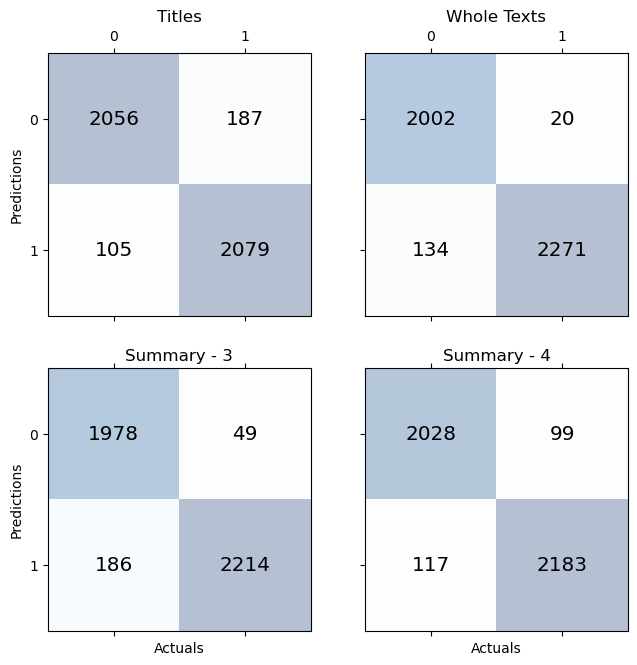

In [70]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(7.5, 7.5))
axs[0,0].matshow(cm1, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm1.shape[0]):
    for j in range(cm1.shape[1]):
        axs[0,0].text(x=j, y=i,s=cm1[i, j], va='center', ha='center', size='x-large')
axs[0,0].set_title('Titles', size= 'large')
axs[0,1].matshow(cm2, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm2.shape[0]):
    for j in range(cm2.shape[1]):
        axs[0,1].text(x=j, y=i,s=cm2[i, j], va='center', ha='center', size='x-large')
axs[0,1].set_title('Whole Texts', size= 'large')
axs[1,0].matshow(cm3, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm3.shape[0]):
    for j in range(cm3.shape[1]):
        axs[1,0].text(x=j, y=i,s=cm3[i, j], va='center', ha='center', size='x-large')
axs[1,0].set_title('Summary - 3', size= 'large')
axs[1,1].matshow(cm4, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm4.shape[0]):
    for j in range(cm4.shape[1]):
        axs[1,1].text(x=j, y=i,s=cm4[i, j], va='center', ha='center', size='x-large')
axs[1,1].set_title('Summary - 4', size= 'large')

for ax in axs.flat:
    ax.set(xlabel = "Actuals", ylabel = "Predictions")

for ax in axs.flat:
    ax.label_outer()

plt.show()

In [71]:
df_results = pd.DataFrame([perf1,perf2,perf3,perf4], columns = ['model','precision','recall','accuracy'])
df_results

,model,precision,recall,accuracy
0,titles,0.917476,0.951923,0.934041
1,whole texts,0.991270,0.944283,0.965213
2,summ3,0.978347,0.922500,0.946917
3,summ4,0.956617,0.949130,0.951208
